In [1]:
import argparse
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['savefig.dpi'] = 300

import sys
sys.path.append("..")
from utilities import *
from torchdiffeq import odeint

# Linear gradient flow
For this example, the observed data is collected on solution trajectories to
\begin{align*}
\dot x_1 = -2x_1 - x_2,\\
\dot x_2 = - x_1 - 2x_2.
\end{align*}
This is of form $\dot x=-\nabla f(x)$ with
\begin{equation*}
f(x_1, x_2) = x^2_1 + x_1x_2 + x^2_2.  
\end{equation*}
This system has critical point $(0,0)$ as a stable node. All solution trajectories tend to $(0,0)$ as $t\to\infty$. We want to extract $f$ from the training data, which is sampled from $8$ trajectories on domain $[-2,2]\times[-2,2]$ with time interval $[0,5]$ and time step $\Delta t=0.05$. The neural network $G$ used to approximate $f$ has $2$ hidden layers of $50$ neurons.

In [2]:
def get_parser():
    parser = argparse.ArgumentParser('Linear gradient flow')
    parser.add_argument('--model_true', type=str, choices=['LGF', 'NGF', 'Pendulum', 'Lorenz'], default='LGF')
    parser.add_argument('--model_ocn', type=str, choices=['OCN', 'OCN_GF'], default='OCN_GF')
    parser.add_argument('--train_time', type=float, default=5)
    parser.add_argument('--step_size', type=int, default=0.05)
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--test_time', type=int, default=5)
    parser.add_argument('--hidden_layers', type=int, default=2)
    parser.add_argument('--hidden_neurons', type=int, default=50)
    return parser

In [3]:
parser = get_parser()
args = parser.parse_args("")
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
ckpt = torch.load('checkpoint/pretrained/LGF-G2x50-T5.0-bs2', map_location=torch.device('cpu'))

In [10]:
model_true = eval(args.model_true)
model_ocn = eval(args.model_ocn)
y0 = initial_point(args, device)

trf = model_true()
ocn = model_ocn(args)
ocn.load_state_dict(ckpt['params'])

true_y_train, train_t = build_dataset(args, model_true=model_true, data_type='train', y0=y0, device=device)
pred_y_train = odeint(ocn, y0, train_t, method="dopri5")

train_tt = train_t.cpu().numpy()
true_train_yy = true_y_train.cpu().detach().numpy()
pred_train_yy = pred_y_train.cpu().detach().numpy()

## Training results

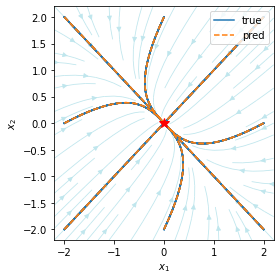

In [5]:
# 1D arrays
x = np.arange(-2.2, 2.4, 0.2)
y = np.arange(-2.2, 2.4, 0.2)
  
# Meshgrid
X,Y = np.meshgrid(x,y)
  
# Assign vector directions
Ex = -2*X - Y
Ey = -X - 2*Y
  
# Depict illustration
plt.figure(figsize=(4,4))
#plt.title('Training results')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.streamplot(X,Y,Ex,Ey, density=0.7, linewidth=0.8, color=(.75,.90,.93))#

plt.plot(true_train_yy[:,0,0], true_train_yy[:,0,1], '-', color='C0', label='true')
plt.plot(pred_train_yy[:,0,0], pred_train_yy[:,0,1], '--', markersize=6, color='C1', label='pred')

for i in range(1, len(y0)):
    plt.plot(true_train_yy[:,:,0], true_train_yy[:,:,1], '-', color='C0')
    plt.plot(pred_train_yy[:,:,0], pred_train_yy[:,:,1], '--', markersize=6, color='C1')

plt.plot(0, 0, 'r*', markersize=10)
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('lgf_phase2')
#plt.savefig('lgf_train')

 It can be seen that all trajectories generated by OCN match the observed data generated by the true dynamical system well. 

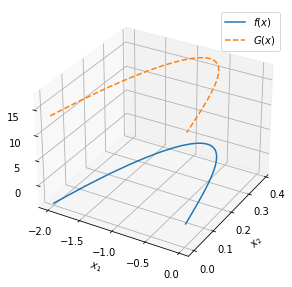

In [11]:
from mpl_toolkits import mplot3d

plt.figure(figsize=(4,4))
ax_func= plt.axes(projection='3d')
ax_func.zaxis._axinfo['juggled'] = (-2,-2,2)
#ax_func.set_title('Learned Function')
ax_func.set_xlabel(r'$x_1$')
ax_func.set_ylabel(r'$x_2$')
ax_func.plot3D(true_train_yy[:,0,0], true_train_yy[:,0,1], trf.F(true_train_yy)[:,0], color='C0', label=r'$f(x)$')
ax_func.plot3D(true_train_yy[:,0,0], true_train_yy[:,0,1], ocn.F(true_y_train).detach().numpy()[:,0], '--', color='C1', label=r'$G(x)$')
plt.legend()

plt.grid(linestyle='--')
plt.tight_layout()
#plt.savefig('plots/lgf_func')

This is a comparison between the true governing function $f(x)$ and the trained neural network $G(x,\cdot)$, where $x$ represents the training data set $\{x_i\}$. There is a distance between them because the original problem is uniquely determined by $f+c$ for any constant $c$. For $G(x,\cdot)$ that satisfies the original problem, $G(x,\cdot)+c$ also satisfies the original problem for any constant $c$. 

# Testing results
We also verify the generalization performance of OCN by applying it to some test data, which are some initial points generated randomly over the same domain and do not appear in the dataset used for training.

In [7]:
test_y0 = torch.tensor([[-1., -2.], [-2., -1.], [-2., 1.], [-1., 2.], [1., -2.], [1., 2.], [2., 1.], [2., -1.]])
test_y0.requires_grad = True

true_y_test, test_t = build_dataset(args, model_true=model_true, data_type='test', y0=test_y0, device=device)
pred_y_test = odeint(ocn, test_y0, test_t, method="dopri5")

test_tt = test_t.cpu().numpy()
true_test_yy = true_y_test.cpu().detach().numpy()
pred_test_yy = pred_y_test.cpu().detach().numpy()

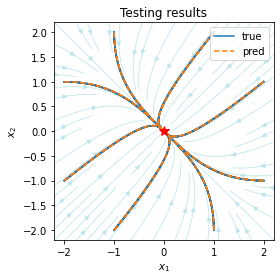

In [9]:
# 1D arrays
x = np.arange(-2.2, 2.4, 0.2)
y = np.arange(-2.2, 2.4, 0.2)
  
# Meshgrid
X,Y = np.meshgrid(x,y)
  
# Assign vector directions
Ex = -2*X - Y
Ey = -X - 2*Y
  
# Depict illustration
plt.figure(figsize=(4,4))
plt.title('Testing results')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.streamplot(X,Y,Ex,Ey, density=0.7, linewidth=0.8, color=(.75,.90,.93))#

plt.plot(true_test_yy[:,0,0], true_test_yy[:,0,1], '-', color='C0', label='true')
plt.plot(pred_test_yy[:,0,0], pred_test_yy[:,0,1], '--', markersize=6, color='C1', label='pred')

for i in range(1, len(test_y0)):
    plt.plot(true_test_yy[:,:,0], true_test_yy[:,:,1], '-', color='C0')
    plt.plot(pred_test_yy[:,:,0], pred_test_yy[:,:,1], '--', markersize=6, color='C1')

plt.plot(0, 0, 'r*', markersize=10)

plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('lgf_test')